In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

In [ ]:
from scipy.spatial import cKDTree

# Force-field constants (CHARMM22 for graphene)
k_b     = 469.0   # kcal/(mol·Å²)
b0      = 1.42    # Å

k_theta = 63.0    # kcal/(mol·rad²)
theta0  = 120.0 * np.pi/180.0  # convert degrees → radians

bond_cutoff = 1.6 
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from collections import defaultdict

# FORCE FIELD CONSTANTS 
k_b     = 469.0   # kcal/(molÅ²)
b0      = 1.42    # Å
k_theta = 63.0    # kcal/(molrad²)
theta0  = 120.0 * np.pi/180.0


def find_dynamic_cutoff(positions, factor=1.2):
    dists, _ = cKDTree(positions).query(positions, k=4)  # 0=self, 1–3 = first 3 neighbors
    bond_len = np.median(dists[:, 3])
    return factor * bond_len

def build_neighbor_list(positions):
    tree = cKDTree(positions)
    R    = find_dynamic_cutoff(positions)
    raw  = tree.query_ball_point(positions, r=R)

    N     = len(positions)
    neigh = [set() for _ in range(N)]

    for i, cand in enumerate(raw):
        # compute exact distances
        ds = np.linalg.norm(positions[cand] - positions[i], axis=1)
        # zip, sort, drop self, pick 3
        picks = [idx for idx, _ in sorted(zip(cand, ds), key=lambda x: x[1]) if idx != i][:3]
        for j in picks:
            neigh[i].add(j)

    # symmetrize
    for i in range(N):
        for j in neigh[i]:
            neigh[j].add(i)

    return [list(s) for s in neigh]

def compute_angle(p_i, p_c, p_j):
    v1 = p_i - p_c
    v2 = p_j - p_c
    cosang = np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2))
    cosang = np.clip(cosang, -1.0, 1.0)
    return np.arccos(cosang)


In [ ]:

k_b     = 469.0    # kcal/(molÅ²)
b0      = 1.42     # Å
k_theta = 63.0     # kcal/(mol·rad²)
theta0  = 120.0 * np.pi/180.0  # radians
k_B     = 0.0019872041         # kcal/(molK)

def compute_forces_and_counts(coords):
    """
    Given coords (n_atoms,2), build neighbor_list, then
    - compute forces array (n_atoms,2)
    - return forces, n_bonds, n_angles
    """
    neighbor_list = build_neighbor_list(coords)

    # build bond_list (i<j)
    bonds = []
    for i, nbrs in enumerate(neighbor_list):
        for j in nbrs:
            if j > i:
                bonds.append((i, j))
    bond_list = np.array(bonds, dtype=int)
    n_bonds = len(bond_list)

    # build angles_idx
    angles_idx = []
    for c, nbrs in enumerate(neighbor_list):
        if len(nbrs) < 2:
            continue
        for ii in range(len(nbrs)):
            for jj in range(ii+1, len(nbrs)):
                angles_idx.append((nbrs[ii], c, nbrs[jj]))
    angles_idx = np.array(angles_idx, dtype=int)
    n_angles = len(angles_idx)

    # init forces
    forces = np.zeros((11040, 2))

    # bond forces
    for i, j in bond_list:
        rij  = coords[i] - coords[j]
        b    = np.linalg.norm(rij)
        dUdb = 2 * k_b * (b - b0)
        fij  = -dUdb * (rij / b)
        forces[i] +=  fij
        forces[j] += -fij

    # angle forces
    for i, c, j in angles_idx:
        vci = coords[i] - coords[c]
        vcj = coords[j] - coords[c]
        ri, rj = np.linalg.norm(vci), np.linalg.norm(vcj)
        cosθ = np.dot(vci, vcj) / (ri * rj)
        cosθ = np.clip(cosθ, -1.0, 1.0)
        θ    = np.arccos(cosθ)
        dUdθ = 2 * k_theta * (θ - theta0)
        sinθ = np.sqrt(1.0 - cosθ*cosθ)
        if sinθ < 1e-8:
            continue
        fi = -dUdθ/(ri*sinθ) * ((vcj/rj) - cosθ*(vci/ri))
        fj = -dUdθ/(rj*sinθ) * ((vci/ri) - cosθ*(vcj/rj))
        fc = -(fi + fj)
        forces[i] += fi
        forces[j] += fj
        forces[c] += fc

    return forces, n_bonds, n_angles

sum_F2     = 0.0
sum_bonds  = 0
sum_angles = 0


forces, nb, na = compute_forces_and_counts(frame)
sum_F2     += np.sum(np.linalg.norm(forces, axis=1)**2)
sum_bonds  += nb
sum_angles += na

trace_bonds  = 4.0 * k_b
trace_angles = (14.0/3.0) * k_theta

sum_trace = trace_bonds*sum_bonds + trace_angles*sum_angles

T_conf = sum_F2 / (k_B * sum_trace)

print(f"Configurational temperature = {T_conf:.1f} K")


'\nforces, nb, na = compute_forces_and_counts(frame)\nsum_F2     += np.sum(np.linalg.norm(forces, axis=1)**2)\nsum_bonds  += nb\nsum_angles += na\n\ntrace_bonds  = 4.0 * k_b\ntrace_angles = (14.0/3.0) * k_theta\n\nsum_trace = trace_bonds*sum_bonds + trace_angles*sum_angles\n\nT_conf = sum_F2 / (k_B * sum_trace)\n\nprint(f"Configurational temperature = {T_conf:.1f} K")\n'

In [1]:
import numpy as np
from scipy.spatial import cKDTree


k_b     = 300.0    # bond force constant [kcal/(mol·Å²)] (example)
b0      = 1.42     # equilibrium bond length [Å] (example)
k_th = 40.0     # angle force constant [kcal/(mol·rad²)] (example)
th0  = 120.0 * np.pi/180.0  # equilibrium angle [rad] (example)
def find_dynamic_cutoff(positions, factor=1.2):
    dists, _ = cKDTree(positions).query(positions, k=4)
    bond_len = np.median(dists[:, 3])
    return factor * bond_len

def build_neighbor_list(positions):
    tree = cKDTree(positions)
    R    = find_dynamic_cutoff(positions)
    raw  = tree.query_ball_point(positions, r=R)
    N     = len(positions)
    neigh = [set() for _ in range(N)]
    for i, cand in enumerate(raw):
        ds = np.linalg.norm(positions[cand] - positions[i], axis=1)
        picks = [idx for idx, _ in sorted(zip(cand, ds), key=lambda x: x[1])
                 if idx != i][:3]
        for j in picks:
            neigh[i].add(j)
    for i in range(N):
        for j in neigh[i]:
            neigh[j].add(i)
    return [list(s) for s in neigh]
def compute_total_energy(coords):
    nbrs = build_neighbor_list(coords)
    # bonds
    E_bond = 0.0
    for i, neigh in enumerate(nbrs):
        for j in neigh:
            if j>i:
                b = np.linalg.norm(coords[i]-coords[j])
                E_bond += k_b*(b - b0)**2
    # angles
    E_ang = 0.0
    for c, neigh in enumerate(nbrs):
        L = len(neigh)
        if L<2: 
            continue
        for ii in range(L):
            for jj in range(ii+1, L):
                i, j = neigh[ii], neigh[jj]
                vi = coords[i]-coords[c]
                vj = coords[j]-coords[c]
                cosθ = np.dot(vi,vj)/(np.linalg.norm(vi)*np.linalg.norm(vj))
                cosθ = np.clip(cosθ, -1, 1)
                θ = np.arccos(cosθ)
                E_ang += k_theta*(θ - theta0)**2
    return E_bond + E_ang

import numpy as np

def per_atom_energies(coords):
    """
    Split each bond energy ½–½, each angle energy ⅓–⅓–⅓,
    return e_atom[N] in kcal/mol.
    """
    N      = len(coords)
    e_atom = np.zeros(N)
    nbrs   = build_neighbor_list(coords)

    # ── bond contributions ─────────────────────────────────────
    for i, neigh in enumerate(nbrs):
        for j in neigh:
            if j > i:
                b  = np.linalg.norm(coords[i]-coords[j])
                Eb = k_b*(b-b0)**2
                e_atom[i] += 0.5*Eb
                e_atom[j] += 0.5*Eb

    # ── angle contributions ────────────────────────────────────
    for c, neigh in enumerate(nbrs):
        L = len(neigh)
        if L < 2:                  # need ≥2 neighbours to form an angle
            continue
        for ii in range(L):
            for jj in range(ii+1, L):
                i, j = neigh[ii], neigh[jj]
                vi, vj = coords[i]-coords[c], coords[j]-coords[c]
                cos_t = np.dot(vi,vj)/(np.linalg.norm(vi)*np.linalg.norm(vj))
                cos_t = np.clip(cos_t, -1.0, 1.0)
                theta = np.arccos(cos_t)
                Ea    = k_th*(theta-th0)**2
                share = Ea/3.0
                e_atom[i] += share
                e_atom[c] += share
                e_atom[j] += share

    return e_atom

def shannon_entropy(values, bins='fd'):
    """
    values : 1-D array of per-atom energies (or any scalar)
    bins   : 'fd' (Freedman–Diaconis) or an int
    returns S  (dimensionless, i.e. in units of k_B = 1)
    """
    counts, edges = np.histogram(values, bins=bins, density=False)
    p = counts / counts.sum()          # normalised probabilities
    p = p[p>0]                         # drop empty bins
    return -np.sum(p * np.log(p))

In [2]:
import numpy as np

T = [8350, 8700, 9250, 9400, 9500, 9669, 9700, 9765, 9769, 9750, 9850, 9785, 9875, 9900, 9690, 10020, 10350, 10800, 11000]
T = np.sort(T)

def load_min_data(temp, base_dir="../output/GAMMAS"):
    path = f"{base_dir}/{temp}/min_{temp}K.data"
    return np.loadtxt(path, skiprows=15, usecols=(2, 3))

datasets = {str(t): load_min_data(t) for t in T}

Emin, Emax, nbins = 0.0, 10.0, 200
edges = np.linspace(Emin, Emax, nbins+1)

def shannon_entropy_fixed(data, edges):
    counts, _ = np.histogram(data, bins=edges)
    p = counts / counts.sum()
    p = p[p > 0]
    return -np.sum(p * np.log(p))

all_ea = np.hstack([per_atom_energies(coords) for coords in datasets.values()])

for name, coords in datasets.items():
    S = shannon_entropy_fixed(per_atom_energies(coords), edges)
    print(f"{name:8s}: S = {S:.3f}")


8350    : S = 0.245
8700    : S = 0.483
9250    : S = 1.003
9400    : S = 1.627
9500    : S = 1.827
9669    : S = 1.838
9690    : S = 3.826
9700    : S = 4.521
9750    : S = 3.655
9765    : S = 3.504
9769    : S = 2.301
9785    : S = 3.068
9850    : S = 4.008
9875    : S = 4.454
9900    : S = 4.058
10020   : S = 4.484
10350   : S = 4.910
10800   : S = 4.969
11000   : S = 4.746


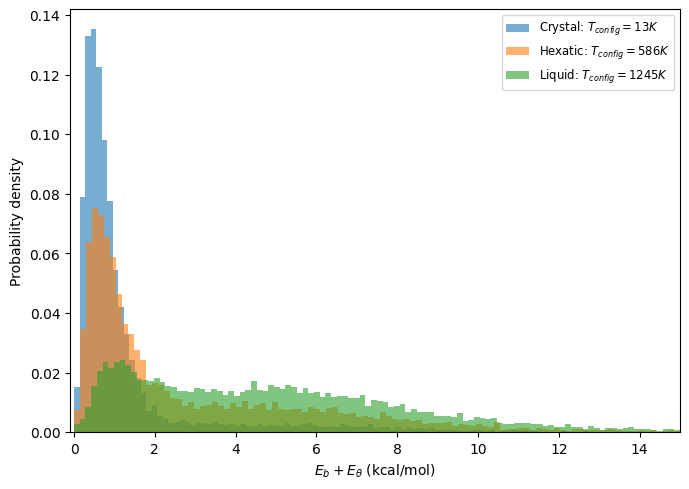

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.stats import norm, gamma, lognorm, kstest

k_b, b0   = 469.0, 1.42
k_th, th0 = 63.0, 120*np.pi/180

def build_neighbor_list(coords):
    tree = cKDTree(coords)
    raw  = tree.query_ball_point(coords, r=1.6)
    neigh = [set() for _ in coords]
    for i, cands in enumerate(raw):
        ds = np.linalg.norm(coords[cands] - coords[i], axis=1)
        picks = [idx for idx,_ in sorted(zip(cands,ds), key=lambda x:x[1]) if idx!=i][:3]
        for j in picks:
            neigh[i].add(j)
    for i in range(len(coords)):
        for j in list(neigh[i]):
            neigh[j].add(i)
    return [list(n) for n in neigh]

def per_atom_energies(coords):
    e = np.zeros(len(coords))
    nbrs = build_neighbor_list(coords)
    for i,nbr in enumerate(nbrs):
        for j in nbr:
            if j>i:
                b = np.linalg.norm(coords[i]-coords[j])
                Eb = k_b*(b-b0)**2
                e[i] += 0.5*Eb
                e[j] += 0.5*Eb

    for c,nbr in enumerate(nbrs):
        L = len(nbr)
        if L<2: continue
        for ii in range(L):
            for jj in range(ii+1, L):
                i,j = nbr[ii], nbr[jj]
                vi, vj = coords[i]-coords[c], coords[j]-coords[c]
                cosθ = np.dot(vi,vj)/(np.linalg.norm(vi)*np.linalg.norm(vj))
                cosθ = np.clip(cosθ,-1,1)
                θ = np.arccos(cosθ)
                Eθ = k_th*(θ-th0)**2
                e[i] += Eθ/3
                e[c] += Eθ/3
                e[j] += Eθ/3
    return e

datasets = [("Crystal", "13 K", np.loadtxt("../output/GAMMAS/9669/anneal_9669K.data", skiprows=15, usecols=(2,3))),
           ("Hexatic", "586 K", np.loadtxt("../output/GAMMAS/9900/anneal_9900K.data", skiprows=15, usecols=(2,3))),
           ("Liquid",  "1245 K", np.loadtxt("../output/GAMMAS/10350/anneal_10350K.data", skiprows=15, usecols=(2,3)))]

plt.figure(figsize=(7,5))
x = np.linspace(0, 10, 500)

for name, T, coords in datasets:
    ea = per_atom_energies(coords)

    weights = np.ones_like(ea) / ea.size

    plt.hist(
        ea,
        bins=300,              
        weights=weights,
        alpha=0.6,
        label=fr"{name}: $T_{{config}}={T}$"
    )

# Final touches
plt.xlim(-0.1, 15)
plt.xlabel(r"$E_b + E_\theta$ (kcal/mol)")
plt.ylabel("Probability density")
plt.legend(fontsize='small', ncol=1)
plt.tight_layout()
plt.savefig("E_dist.pdf", dpi=800)
plt.show()


Mean instantaneous T ≃ 0 K


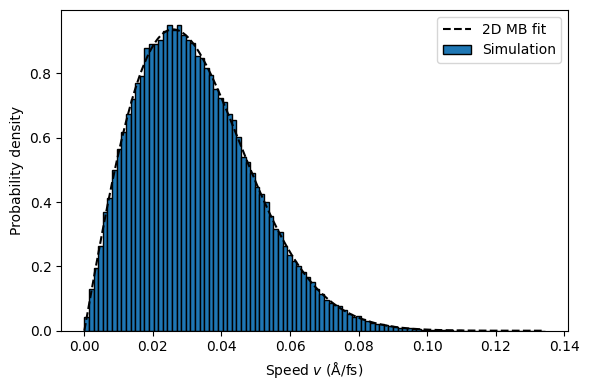

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# (1) load vx, vy exactly as before; these come out in Å/ps
def load_vxy(dump_file, start=110, end=120, n_atoms=11040):
    frames = []; vxs = []; vys = []
    cur = 0
    with open(dump_file) as f:
        while True:
            line = f.readline()
            if not line:
                break
            if line.startswith("ITEM: TIMESTEP"):
                cur += 1
                f.readline()                      # skip timestep
                f.readline(); f.readline(); f.readline()  # skip natoms & 3 box lines
                f.readline(); f.readline(); f.readline()  # actually box can be 3 lines
                header = f.readline().split()[2:]  # e.g. ['id','vx','vy','vz']
                idx = {c:i for i,c in enumerate(header)}
                # read atoms
                if start <= cur <= end:
                    for i in range(n_atoms):
                        parts = f.readline().split()
                        vxs.append(float(parts[idx['vx']]))   # in Å/ps
                        vys.append(float(parts[idx['vy']]))   # in Å/ps
                else:
                    # skip atom lines
                    for i in range(n_atoms):
                        f.readline()
    return np.array(vxs), np.array(vys)

# point this at your real file:
dump_path = '../output/GAMMAS/9750/velocities_9750.txt'
vxs_Aps, vys_Aps = load_vxy(dump_path)

# (2) convert from Å/ps → m/s:
#     1 Å/ps = (1e-10 m)/(1e-12 s) = 1e2 m/s
conv = 1/1000
vxs = vxs_Aps * conv
vys = vys_Aps * conv

# (3) compute speeds in m/s and estimate T_inst
speeds = np.sqrt(vxs**2 + vys**2)  # now in m/s
mC    = 12.0 * 1.66054e-27         # mass of carbon in kg
kB    = 1.38064852e-23            # Boltzmann constant in J/K

# For a 2D system:  <v^2> = 2 kB T / m  →  T = m <v^2> / (2 kB)
T_inst = mC * np.mean(speeds**2) / (2*kB)
print(f"Mean instantaneous T ≃ {T_inst:.0f} K")

# (4) build histogram of speeds in SI (m/s)
counts, bins = np.histogram(speeds, bins=100, density=True)
centers = 0.5*(bins[:-1] + bins[1:])

# theoretical 2D Maxwell–Boltzmann in SI (m/s)
def maxwell2D_SI(v, T):
    """
    f(v) = (m / (k_B T)) * v * exp(-m v^2 / (2 k_B T))
    This is normalized so that ∫_0^∞ f(v) dv = 1  (in 2D).
    """
    return (mC / (kB * T)) * v * np.exp(-mC * v**2 / (2*kB * T))

# (5) optional: fit T to the simulated histogram
popt, _ = curve_fit(lambda v, T: maxwell2D_SI(v, T), centers, counts, p0=[T_inst])
T_fit_si = popt[0]

# (6) plot in SI
plt.figure(figsize=(6,4))
plt.bar(centers, counts/25, width=(bins[1]-bins[0]), edgecolor='k',  label='Simulation')
v_lin = np.linspace(0, centers.max(), 200)
plt.plot(v_lin, maxwell2D_SI(v_lin, T_fit_si)/25, 'k--', label="2D MB fit")
plt.xlabel('Speed $v$ (Å/fs)')
plt.ylabel('Probability density')
plt.legend()
plt.tight_layout()
plt.savefig("../output/velocity.png", dpi=200)
plt.show()


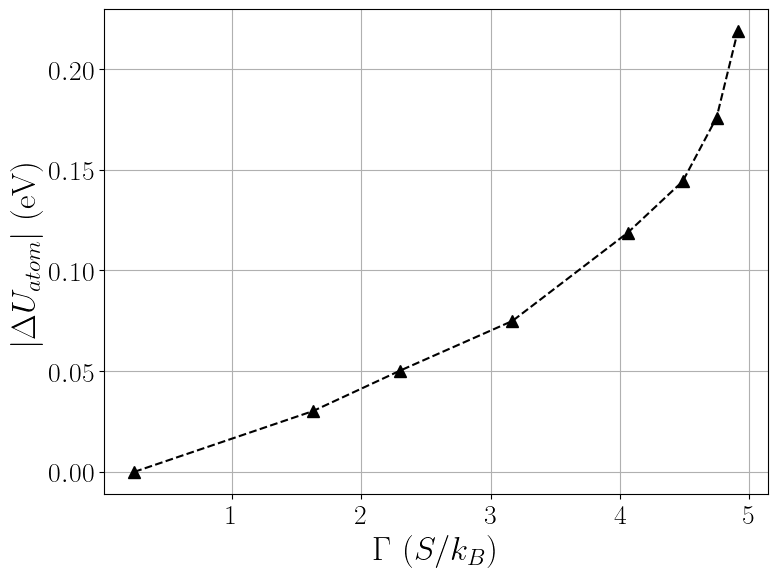

In [ ]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    # optionally make all font sizes a bit larger for publication
    "font.size": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 12,
})

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

import numpy as np
import matplotlib.pyplot as plt

def plot_deltaU(T_vals, G_vals, U_ideal=-7.38402131072368):
    # Ensure inputs are iterable
    T_vals = np.atleast_1d(T_vals)
    G_vals = np.atleast_1d(G_vals)
    if len(T_vals) != len(G_vals):
        raise ValueError("T_vals and G_vals must have the same length.")
    
    deltaUs = []
    for T in T_vals:
        data = np.loadtxt(f"../output/GAMMAS/{T}/energy_{T}.txt")
        U_defect = data[-1, -1]
        deltaUs.append(U_defect - U_ideal)
    
    plt.figure(figsize=(8,6))
    plt.plot(G_vals, deltaUs, marker='^',markersize= 8, c='k', linestyle='--')
    plt.xlabel(r"$\Gamma \,\, (S/k_B)$", fontsize=24)
    plt.ylabel(r"$|\Delta U_{atom}|$ (eV)", fontsize =24)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("../output/deltaU.png", dpi=800)
    plt.show()


T_list = np.loadtxt("data/S.txt")[:,0].astype(int)
G_list = np.loadtxt("data/S.txt")[:,1]

plot_deltaU(T_list, G_list)


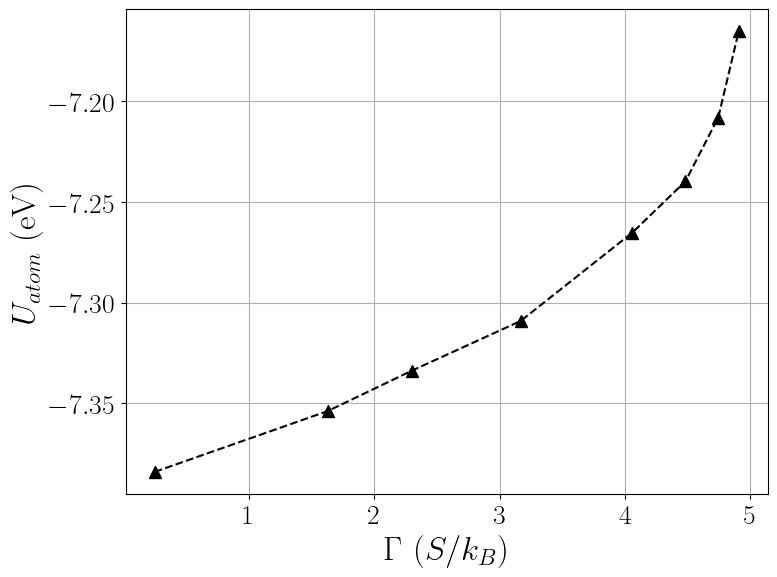

In [32]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    # optionally make all font sizes a bit larger for publication
    "font.size": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 12,
})

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

import numpy as np
import matplotlib.pyplot as plt

def plot_deltaU(T_vals, G_vals, U_ideal=-7.38402131072368):
    # Ensure inputs are iterable
    T_vals = np.atleast_1d(T_vals)
    G_vals = np.atleast_1d(G_vals)
    if len(T_vals) != len(G_vals):
        raise ValueError("T_vals and G_vals must have the same length.")
    
    deltaUs = []
    for T in T_vals:
        data = np.loadtxt(f"../output/GAMMAS/{T}/energy_{T}.txt")
        U_defect = data[-1, -1]
        deltaUs.append(U_defect)
    
    plt.figure(figsize=(8,6))
    plt.plot(G_vals, deltaUs, marker='^',markersize= 8, c='k', linestyle='--')
    plt.xlabel(r"$\Gamma \,\, (S/k_B)$", fontsize=24)
    plt.ylabel(r"$U_{atom}$ (eV)", fontsize =24)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("../output/Uatom.png", dpi=800)
    plt.show()


T_list = np.loadtxt("data/S.txt")[:,0].astype(int)
G_list = np.loadtxt("data/S.txt")[:,1]

plot_deltaU(T_list, G_list)
